In [37]:
import os

# 顶层目录
base_dir = "/Users/ui21149/PycharmProjects/rep_measureGPR/WRDS/Spellchecked Copy"

# 用于保存每个 headline_with_q_year 子目录的 .txt 文件数量
txt_counts = {}
total_txt = 0

# 遍历所有子目录，查找名为 headline_with_q_year 的文件夹
for root, dirs, files in os.walk(base_dir):
    for dir_name in dirs:
        if dir_name == "headline_with_q_year":
            target_dir = os.path.join(root, dir_name)
            txt_files = [
                f for f in os.listdir(target_dir)
                if f.endswith(".txt") and os.path.isfile(os.path.join(target_dir, f))
            ]
            count = len(txt_files)
            txt_counts[target_dir] = count
            total_txt += count

# 输出每个 headline_with_q_year 目录的 txt 文件数和比例
for path, count in sorted(txt_counts.items()):
    proportion = count / total_txt if total_txt > 0 else 0
    print(f"{path}: {count} files, {proportion:.2%} of total")

# 总文件数
print(f"\nTotal .txt files: {total_txt}")

/Users/ui21149/PycharmProjects/rep_measureGPR/WRDS/Spellchecked Copy/transcripts_2004/headline_with_q_year: 1 files, 0.00% of total
/Users/ui21149/PycharmProjects/rep_measureGPR/WRDS/Spellchecked Copy/transcripts_2005/headline_with_q_year: 2 files, 0.00% of total
/Users/ui21149/PycharmProjects/rep_measureGPR/WRDS/Spellchecked Copy/transcripts_2006/headline_with_q_year: 71 files, 0.03% of total
/Users/ui21149/PycharmProjects/rep_measureGPR/WRDS/Spellchecked Copy/transcripts_2007/headline_with_q_year: 139 files, 0.05% of total
/Users/ui21149/PycharmProjects/rep_measureGPR/WRDS/Spellchecked Copy/transcripts_2008/headline_with_q_year: 411 files, 0.16% of total
/Users/ui21149/PycharmProjects/rep_measureGPR/WRDS/Spellchecked Copy/transcripts_2009/headline_with_q_year: 370 files, 0.14% of total
/Users/ui21149/PycharmProjects/rep_measureGPR/WRDS/Spellchecked Copy/transcripts_2010/headline_with_q_year: 1641 files, 0.63% of total
/Users/ui21149/PycharmProjects/rep_measureGPR/WRDS/Spellchecked Co

In [38]:
# 将结果整理成一个字典：年份（字符串） -> 比例（float，单位为 0-1 之间的小数）
year_to_ratio = {}

for path, count in txt_counts.items():
    # 假设路径中包含 transcripts_YYYY，例如 .../transcripts_2024/...
    for segment in path.split(os.sep):
        if segment.startswith("transcripts_"):
            year = segment.replace("transcripts_", "")
            proportion = count / total_txt if total_txt > 0 else 0
            year_to_ratio[year] = proportion
            break  # 找到后就跳出 segment 循环

# 使用示例：输入年份获取对应比例
query_year = "2016"
print(f"Year {query_year}: {year_to_ratio.get(query_year, 'Not found'):.2%} of total")

Year 2016: 6.08% of total


In [39]:
# 基于 year_to_ratio 字典，创建新的字典：每年应抽取的 paragraph 数量（四舍五入为整数）
year_to_paragraphs = {
    year: round(ratio * 100000)
    for year, ratio in year_to_ratio.items()
}
# 输出所有年份对应的段落数量
print("Year\tParagraphs")
for year in sorted(year_to_paragraphs.keys()):
    count = year_to_paragraphs[year]
    print(f"{year}\t{count}")

Year	Paragraphs
2004	0
2005	1
2006	27
2007	53
2008	157
2009	141
2010	625
2011	4544
2012	4509
2013	4522
2014	5647
2015	6137
2016	6079
2017	6241
2018	6867
2019	7210
2020	8455
2021	8811
2022	9409
2023	9505
2024	9357
2025	1704


In [40]:
#gpr match
import re

# 地缘政治词列表（支持 `*` 通配符）
geo_political_terms_with_star = [
    "war", "military", "terror*", "geopolitical", "conflict", "Middle East", "Iraq", "Afghanistan",
    "Iran", "Syria", "Libya", "Ukrain*", "Russia*", "North Korea", "Venezuela", "coup",
    "expropriation", "confiscation", "nationalism", "security", "protest*", "country", "countries",
    "political", "retaliation", "unrest", "geograph*", "troop*", "sanction", "sanctions", "embargo",
    "wars", "warfare", "army", "navy", "weapon*", "combat", "missile*", "immigration", "diplomacy"
]

# 风险/不利事件词列表（支持 `*` 通配符）
risk_terms_with_star = [
    "risk*", "uncertain*", "variab*", "chance*", "possib*", "pending", "doubt*", "prospect*",
    "bet", "bets", "betting", "exposed", "likel*", "threat*", "probab*", "unknown*", "potential",
    "concern*", "tension*", "issue*", "instability", "cautio*", "fear*", "volatil*", "varying",
    "unclear", "speculative", "hesitant", "headwind*", "backlog*", "dispute", "disrupt*", "worry*",
    "worries", "hurdle*", "obstacle*", "disturbance*", "hostil*", "unrest", "conflict", "pressure*",
    "crisis", "trigger*", "impact", "peril*", "effect*", "acts", "attack*", "incident*"
]

# 将 `*` 号转换为正则表达式
def compile_patterns(terms):
    return [re.compile(rf"^{re.escape(term).replace(r'\*', '.*')}$") for term in terms]

geo_political_patterns = compile_patterns(geo_political_terms_with_star)
risk_patterns = compile_patterns(risk_terms_with_star)

# 文本预处理
def clean_text(text):
    # 去除 HTML 标签
    text = re.sub(r'<.*?>', ' ', text)
    # 去除标点符号和特殊字符（只保留字母、数字、空格）
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    # 去除额外的空格
    text = re.sub(r'\s+', ' ', text).strip()
    return text.lower()

# 计算地缘政治风险指数
def calculate_geopolitical_risk(text):
    clean_words = clean_text(text).split()
    total_words = len(clean_words)
    
    geo_mentions = 0  # 匹配次数
    matched_words = []  # 存储匹配的地缘政治+风险词

    for i, word in enumerate(clean_words):
        # 检查当前单词是否是地缘政治相关词
        if any(pattern.match(word) for pattern in geo_political_patterns):
            # 在前后 10 个单词范围内检查风险词
            for j in range(max(0, i-10), min(i+10, total_words)):
                if j==i:
                    continue
                if any(pattern.match(clean_words[j]) for pattern in risk_patterns):  
                    geo_mentions += 1
                    matched_words.append(f"{word}-{clean_words[j]}")  # 记录匹配的具体词
                    break  # 计数后跳出，避免重复

    # 计算风险指数
    risk_index = geo_mentions / total_words if total_words > 0 else 0
    return risk_index, geo_mentions, total_words, "; ".join(set(matched_words))


In [41]:
import os
import pickle

def collect_unlabeled_paragraphs(year, base_dir="/Users/ui21149/PycharmProjects/rep_measureGPR/WRDS/Spellchecked Copy"):
    """
    根据给定年份，从 headline_with_q_year 目录中抽取与地缘政治相关的段落，
    满足目标数量后保存为 {year}_unlabeled_data.pkl 文件。

    参数：
        year (str or int): 年份（例如 "2004"）
        base_dir (str): 主目录路径，默认为你的项目路径
    """
    year = str(year)
    goal = year_to_paragraphs.get(year)
    if goal is None:
        print(f"Year {year} not found in year_to_paragraphs.")
        return

    print(f"⏳ Processing year {year}, target: {goal} paragraphs...")

    target_dir = os.path.join(base_dir, f"transcripts_{year}", "headline_with_q_year")
    selected_paragraphs = []

    if not os.path.exists(target_dir):
        print(f"❌ Directory not found: {target_dir}")
        return

    txt_files = [
        os.path.join(target_dir, f)
        for f in os.listdir(target_dir)
        if f.endswith(".txt") and os.path.isfile(os.path.join(target_dir, f))
    ]

    for file_path in txt_files:
        with open(file_path, 'r', encoding='utf-8') as f:
            content = f.read()
            paragraphs = [p.strip() for p in content.split('\n') if p.strip()]

            for para in paragraphs:
                match_count = calculate_geopolitical_risk(para)[1]
                if match_count > 0:
                    selected_paragraphs.append(para)

                if len(selected_paragraphs) >= goal:
                    break
        if len(selected_paragraphs) >= goal:
            break

    print(f"✅ Collected {len(selected_paragraphs)} paragraphs for year {year}")
    if len(selected_paragraphs) < goal:
        print(f"⚠️ Still missing {goal - len(selected_paragraphs)} paragraphs to reach goal of {goal}")

    output_path = f"{year}_unlabeled_data.pkl"
    with open(output_path, 'wb') as f:
        pickle.dump(selected_paragraphs, f)

    print(f"📦 Saved to {output_path}")

In [43]:
for year in range(2004, 2026): 
    collect_unlabeled_paragraphs(year)

⏳ Processing year 2004, target: 0 paragraphs...
✅ Collected 0 paragraphs for year 2004
📦 Saved to 2004_unlabeled_data.pkl
⏳ Processing year 2005, target: 1 paragraphs...
✅ Collected 0 paragraphs for year 2005
⚠️ Still missing 1 paragraphs to reach goal of 1
📦 Saved to 2005_unlabeled_data.pkl
⏳ Processing year 2006, target: 27 paragraphs...
✅ Collected 27 paragraphs for year 2006
📦 Saved to 2006_unlabeled_data.pkl
⏳ Processing year 2007, target: 53 paragraphs...
✅ Collected 43 paragraphs for year 2007
⚠️ Still missing 10 paragraphs to reach goal of 53
📦 Saved to 2007_unlabeled_data.pkl
⏳ Processing year 2008, target: 157 paragraphs...
✅ Collected 140 paragraphs for year 2008
⚠️ Still missing 17 paragraphs to reach goal of 157
📦 Saved to 2008_unlabeled_data.pkl
⏳ Processing year 2009, target: 141 paragraphs...
✅ Collected 120 paragraphs for year 2009
⚠️ Still missing 21 paragraphs to reach goal of 141
📦 Saved to 2009_unlabeled_data.pkl
⏳ Processing year 2010, target: 625 paragraphs...
✅ 

In [50]:
count = 0
for year in range(2004, 2026):
    with open(f"unlabeled_data/{year}_unlabeled_data.pkl", "rb") as f:
        data = pickle.load(f)
    count = count + len(data)
print(count)

90363


In [51]:
import os
import pickle
import json

# 存放所有段落的列表
all_paragraphs = []

# 段落唯一编号
current_id = 1

# 循环加载所有年份的 .pkl 文件
for year in range(2004, 2026):
    file_name = f"unlabeled_data/{year}_unlabeled_data.pkl"
    if os.path.exists(file_name):
        with open(file_name, "rb") as f:
            paragraphs = pickle.load(f)
            for para in paragraphs:
                all_paragraphs.append({
                    "id": current_id,
                    "text": para
                })
                current_id += 1
    else:
        print(f"⚠️ File not found: {file_name}")

# 保存为 JSON 文件
output_file = "../data/all_unlabeled_paragraphs.json"
with open(output_file, "w", encoding="utf-8") as f:
    json.dump(all_paragraphs, f, ensure_ascii=False, indent=2)

print(f"✅ Saved {len(all_paragraphs)} paragraphs to {output_file}")

✅ Saved 90363 paragraphs to ../data/all_unlabeled_paragraphs.json


原始段落总数: 90363
保留段落数（中间90%）: 80472
截断范围: 24 ~ 267 words


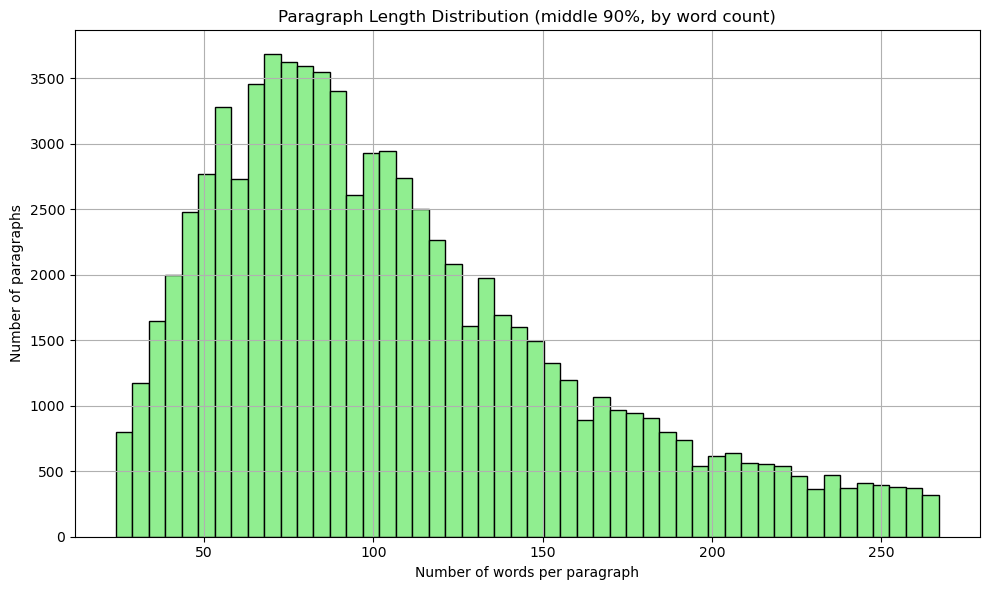

In [63]:
import json
import matplotlib.pyplot as plt
import numpy as np

# 读取 JSON 文件
with open("../data/all_unlabeled_paragraphs.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# 统计每个段落的单词数
lengths = [len(entry["text"].split()) for entry in data]

# 计算分位数
lower_bound = np.percentile(lengths, 1)
upper_bound = np.percentile(lengths, 90)

# 过滤掉最短 5% 和最长 5%
filtered_lengths = [l for l in lengths if lower_bound <= l <= upper_bound]

# 输出统计信息
print(f"原始段落总数: {len(lengths)}")
print(f"保留段落数（中间90%）: {len(filtered_lengths)}")
print(f"截断范围: {lower_bound:.0f} ~ {upper_bound:.0f} words")

# 绘制图像（中间90%）
plt.figure(figsize=(10, 6))
plt.hist(filtered_lengths, bins=50, color='lightgreen', edgecolor='black')
plt.title("Paragraph Length Distribution (middle 90%, by word count)")
plt.xlabel("Number of words per paragraph")
plt.ylabel("Number of paragraphs")
plt.grid(True)
plt.tight_layout()
plt.show()

In [64]:
import json
import numpy as np

# 读取原始 JSON 文件
with open("../data/all_unlabeled_paragraphs.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# 计算每个段落的单词数
lengths = [len(entry["text"].split()) for entry in data]

# 计算截断阈值：去掉最短 1% 和最长 10%
lower_threshold = np.percentile(lengths, 1)
upper_threshold = np.percentile(lengths, 90)

# 过滤数据：只保留中间 89%
filtered_data = [
    entry for entry in data
    if lower_threshold <= len(entry["text"].split()) <= upper_threshold
]

# 重新编号
cleaned_data = [
    {"id": i + 1, "text": entry["text"]}
    for i, entry in enumerate(filtered_data)
]

# 输出统计信息
original_count = len(data)
filtered_count = len(cleaned_data)
removed_count = original_count - filtered_count

print(f"✅ 原始段落总数: {original_count}")
print(f"✅ 删除段落数: {removed_count}")
print(f"✅ 保留段落数: {filtered_count}")

# 保存为新 JSON 文件
output_path = "../data/cleaned_paragraphs.json"
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(cleaned_data, f, ensure_ascii=False, indent=2)

print(f"📁 新文件已保存: {output_path}")

✅ 原始段落总数: 90363
✅ 删除段落数: 9891
✅ 保留段落数: 80472
📁 新文件已保存: ../data/cleaned_paragraphs.json


In [65]:
import json
import random

# 读取清洗后的 JSON 文件
with open("../data/cleaned_paragraphs.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# 设置抽样总数和每组数量
total_sample = 30000
half_sample = total_sample // 2

# 检查是否足够抽样
if len(data) < total_sample:
    raise ValueError(f"❌ 数据不足，只有 {len(data)} 条，无法抽取 {total_sample} 条。")

# 随机抽样
sampled_data = random.sample(data, total_sample)

# 分成两组
team_1_data = sampled_data[:half_sample]
team_2_data = sampled_data[half_sample:]

# 重新编号
team_1_data = [{"id": i + 1, "text": entry["text"]} for i, entry in enumerate(team_1_data)]
team_2_data = [{"id": i + 1, "text": entry["text"]} for i, entry in enumerate(team_2_data)]

# 保存两个文件
with open("../data/team_1.json", "w", encoding="utf-8") as f1:
    json.dump(team_1_data, f1, ensure_ascii=False, indent=2)

with open("../data/team_2.json", "w", encoding="utf-8") as f2:
    json.dump(team_2_data, f2, ensure_ascii=False, indent=2)

print(f"✅ 已将 30000 条段落均分并保存为 team_1.json 与 team_2.json")

✅ 已将 30000 条段落均分并保存为 team_1.json 与 team_2.json


Team 1 平均单词数: 107.15
Team 2 平均单词数: 108.43


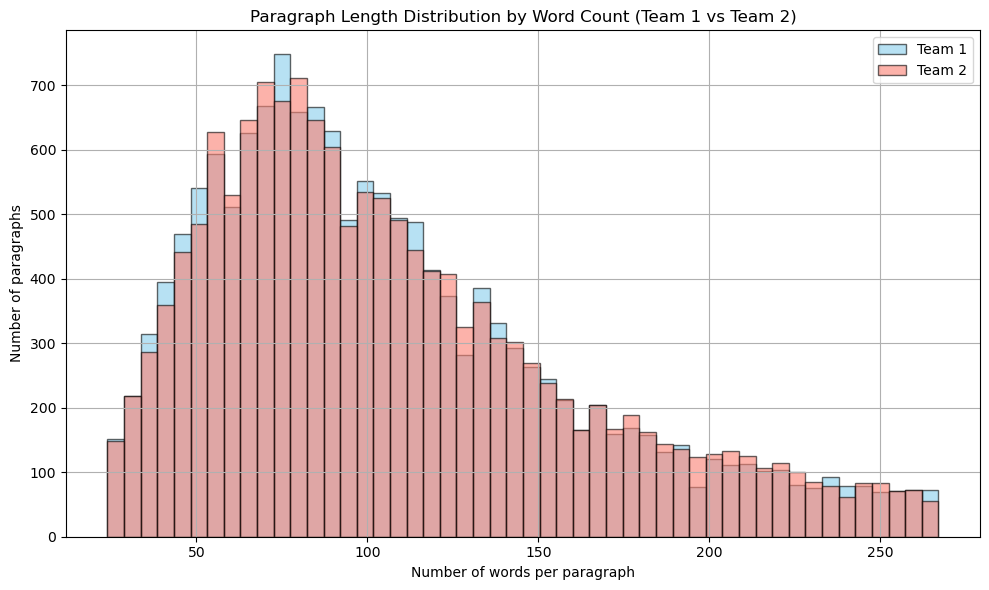

In [67]:
import json
import matplotlib.pyplot as plt

def load_lengths(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    lengths = [len(entry["text"].split()) for entry in data]
    return lengths

# 加载两个团队的段落长度
team_1_lengths = load_lengths("../data/team_1.json")
team_2_lengths = load_lengths("../data/team_2.json")

# 计算并输出平均单词数
print(f"Team 1 平均单词数: {sum(team_1_lengths) / len(team_1_lengths):.2f}")
print(f"Team 2 平均单词数: {sum(team_2_lengths) / len(team_2_lengths):.2f}")

# 绘图
plt.figure(figsize=(10, 6))
plt.hist(team_1_lengths, bins=50, alpha=0.6, label="Team 1", color='skyblue', edgecolor='black')
plt.hist(team_2_lengths, bins=50, alpha=0.6, label="Team 2", color='salmon', edgecolor='black')

plt.title("Paragraph Length Distribution by Word Count (Team 1 vs Team 2)")
plt.xlabel("Number of words per paragraph")
plt.ylabel("Number of paragraphs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [70]:
import json
import random

# 读取清洗后的 JSON 文件
with open("../data/cleaned_paragraphs.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# 设置抽样总数和每组数量
total_sample = 400
group_count = 4
group_size = total_sample // group_count

# 检查是否足够抽样
if len(data) < total_sample:
    raise ValueError(f"❌ 数据不足，只有 {len(data)} 条，无法抽取 {total_sample} 条。")

# 随机抽样并打乱
sampled_data = random.sample(data, total_sample)

# 分组和保存
for i in range(group_count):
    start = i * group_size
    end = start + group_size
    group_data = sampled_data[start:end]
    group_data = [{"id": j + 1, "text": entry["text"]} for j, entry in enumerate(group_data)]
    
    filename = f"../data/test_{i+1}.json"
    with open(filename, "w", encoding="utf-8") as f_out:
        json.dump(group_data, f_out, ensure_ascii=False, indent=2)

print(f"✅ 已将 {total_sample} 条段落平均分成 {group_count} 份")

✅ 已将 400 条段落平均分成 4 份


Team 1 平均单词数: 108.25
Team 2 平均单词数: 113.30
Team 3 平均单词数: 114.79
Team 4 平均单词数: 110.85


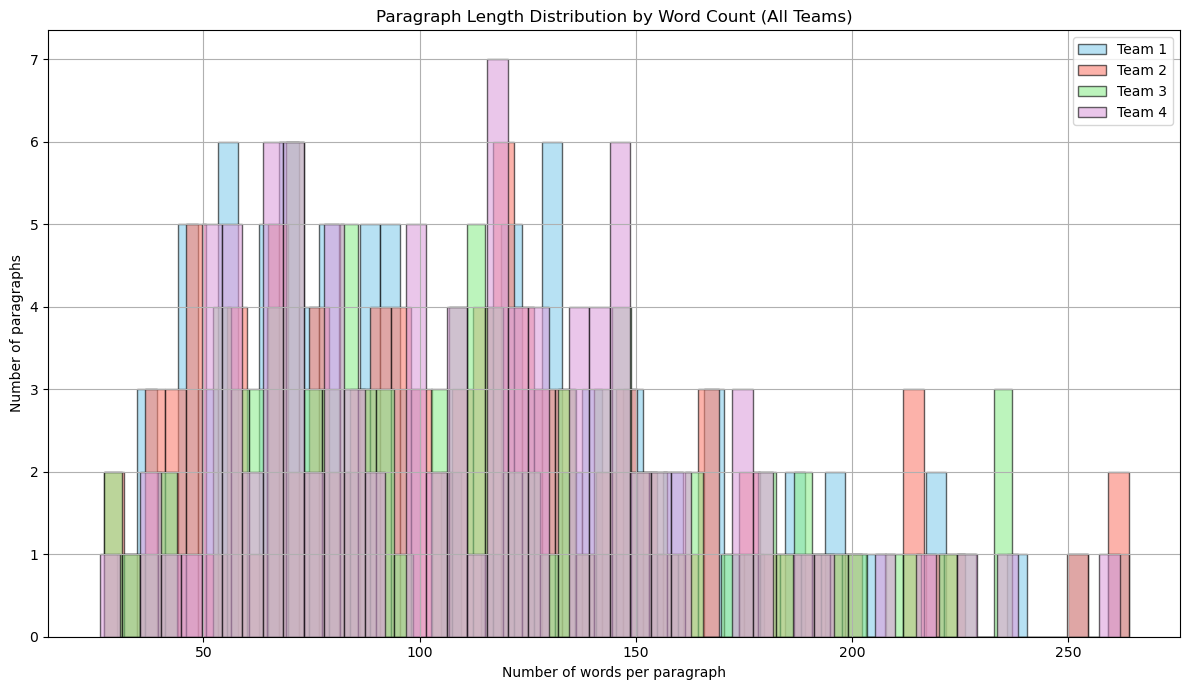

In [71]:
import json
import matplotlib.pyplot as plt

def load_lengths(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    lengths = [len(entry["text"].split()) for entry in data]
    return lengths

# 文件路径与标签定义
teams = {
    "Team 1": "../data/test_1.json",
    "Team 2": "../data/test_2.json",
    "Team 3": "../data/test_3.json",
    "Team 4": "../data/test_4.json"
}

# 存储所有长度和绘图数据
team_lengths = {}

# 加载数据并计算平均值
for team_name, file_path in teams.items():
    lengths = load_lengths(file_path)
    team_lengths[team_name] = lengths
    avg_length = sum(lengths) / len(lengths)
    print(f"{team_name} 平均单词数: {avg_length:.2f}")

# 绘制直方图
plt.figure(figsize=(12, 7))
colors = ['skyblue', 'salmon', 'lightgreen', 'plum']

for i, (team_name, lengths) in enumerate(team_lengths.items()):
    plt.hist(lengths, bins=50, alpha=0.6, label=team_name,
             color=colors[i % len(colors)], edgecolor='black')

plt.title("Paragraph Length Distribution by Word Count (All Teams)")
plt.xlabel("Number of words per paragraph")
plt.ylabel("Number of paragraphs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()